<a href="https://colab.research.google.com/github/thomascerbelaud/M2-IPE-data-energy/blob/main/notebooks/4_1_Bias_Variance_Tradeoff_Answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 4.1 : Bias-variance tradeoff

The goal of this notebook is to highlight the bias-variance tradeoff in a simple model, and plot the bias and variance curves with respect to model

## Visualizing on a simple function

Consider the following function:

$$ f(x) = 1 - x^2 - 2 e^{-100x^2} $$

Fit a polynomial regressor to estimate noisy measurements coming from $f$, with growing complexity. The higher the polynomial degree, and the better the fitted curve pass through the training data points, at the price of stability and generalization.

In [ ]:
import tqdm

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def f(x: np.ndarray) -> np.ndarray:
  """True generative process of the data that we are trying to learn."""
  return 1 - x ** 2 - 2 * np.exp(-100 * x ** 2)
  # return x ** 2


def generate_dataset(num_inputs: int, noise_std: float = 0.0, a_min: float = -1.0, a_max: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
  """Generate a random (X, y) pair of data."""
  x = np.random.uniform(a_min, a_max, size=(num_inputs, 1))
  y = f(x) + np.random.normal(scale=noise_std, size=(num_inputs, 1))
  return x, y


def fit_polynomial_model(x: np.ndarray, y: np.ndarray, degree: int = 1) -> LinearRegression:
  lr = Pipeline([
      ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=False)),
      ("linear_model", LinearRegression())
  ]).fit(x, y.ravel())
  return lr


def plot_data_and_regressor(x_train: np.ndarray, y_train: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, degree: int) -> None:
  x = np.linspace(-1, 1, num=1000)

  # plot true curve
  plt.plot(x, f(x), "-")

  # TODO: plot data points
  plt.plot(x_train.ravel(), y_train.ravel(), ".")

  # TODO: fit polynomial regression
  lr = fit_polynomial_model(x_train, y_train, degree=degree)

  # Plot fitted curve
  plt.plot(x, lr.predict(x.reshape(-1, 1)).ravel())
  plt.xlabel("$x$")
  plt.ylabel("$y$")
  plt.legend([
      "$f(x)$",
      "Dataset with noise",
      "Fitted curve"
  ])

  # TODO: print MSE
  mse = mean_squared_error(y_test, lr.predict(x_test))
  print(f"MSE: {mse:.3f}")


MSE: 0.321


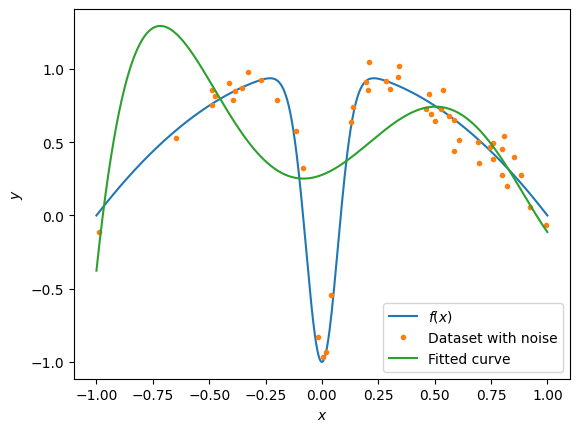

In [ ]:
x_train, y_train = generate_dataset(num_inputs=50, noise_std=0.1)
x_test, y_test = generate_dataset(num_inputs=20, noise_std=0.1)
degree = 5
plot_data_and_regressor(x_train, y_train, x_test, y_test, degree=degree)

## Plotting bias-variance tradeoff

Let us study a linear regression model. Let $X' = (x_1, .., x_n) \in \mathbb{R}^{n \times d}$, and $y = (y_1, .., y_n) \in \mathbb{R}^n$ be the noisy observations s.a.:

$$ y = f(x) + ϵ = X' \beta^T + ϵ, \quad ϵ \sim \mathcal{N}(0, σ) $$

We will have at our disposal a matrix of inputs which is the concatenation of $X'$ with another feature matrix $Z$ that was not use to generate the observations $y$, $X = (X', Z) \in \mathbb{R}^{n \times q}$ with $q > d$. The objective of this section is to train a linear model of growing complexity $p$, i.e. we add complexity by adding new variables, in order, from the columns of $X$. We expect the generalization error to improve up to complexity $p = d$, an then to decrease as we add dummy variables to the training set.

In [1]:
import tqdm

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression

d = 100  # number of features
coefs = np.array([87.0580698 , 86.04083468, 72.64348442, 45.45118925, 41.77504125, 31.0259999 , 26.09989212, 16.60838184, 11.64048518,  8.57020267])
coefs = np.concatenate([coefs, np.zeros(d - len(coefs))])


def f(x: np.ndarray) -> np.ndarray:
  """True generative process of the data that we are trying to learn."""
  return x @ coefs


def generate_dataset(num_inputs: int, noise_std: float = 0.0, a_min: float = -1.0, a_max: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
  """Generate a random (X, y) pair of data."""
  x = np.random.uniform(-1.0, 1.0, size=(num_inputs, d))
  y = f(x) + np.random.normal(scale=noise_std, size=num_inputs)
  return x, y


def fit_linear_model(x: np.ndarray, y: np.ndarray, k_best: int = 1) -> LinearRegression:
  lr = LinearRegression(fit_intercept=False).fit(x[:, :k_best], y.ravel())
  return lr

Remember the following formulae for the bias and variance of the estimator $\hat{f}(X) = X \beta^T$, given that we know the true generative function $f$, at input $x_0$. The expectation is computed over random training sets $\mathcal{T}$ generated using the `generate_dataset` function, for a number of rounds $R$.

\begin{align}
  \textrm{MSE}(x_0) &= \textrm{Bias}^2(\hat{f}; x_0) + \textrm{Var}(\hat{f}; x_0) \\
  \textrm{Bias}(\hat{f}; x_0) &= f(x) - \mathbb{E}_\mathcal{T}[\hat{f}(x_0)] \\
  &= f(x_0) - \dfrac{1}{R} \sum_{i=1}^R \hat{f}(x_0) \\
  \textrm{Var}(\hat{f}; x_0) &= \mathbb{E}_\mathcal{T}\Big[\Big(\hat{f}(x_0) - \mathbb{E}_\mathcal{T}[\hat{f}(x_0)] \Big)^2 \Big] \\
  &= \dfrac{1}{R} \sum_{i=1}^R\Big(\hat{f}(x_0) - \dfrac{1}{R} \sum_{i=1}^R \hat{f}(x_0)\Big)^2
\end{align}

Now, given a test set $\mathcal{T}'$, we can marginalise the estimated bias (squared) and variance over $x_0$ to estimate the squared bias and variance of the estimator, and discretizing the integral over $\mathcal{T}'$. Remember that our goal is to estimate the term in the bias-variance decomposition, which is given at $x$, but that we want to marginalize / average to study our estimator generalization ability.

\begin{align}
  \textrm{Bias}^2(\hat{f}) &= \dfrac{1}{|\mathcal{T}|} \sum_{x_0 \in \mathcal{T}'} \textrm{Bias}^2(\hat{f}; x_0) \\
  \textrm{Var}(\hat{f}) &= \dfrac{1}{|\mathcal{T}|} \sum_{x_0 \in \mathcal{T}'} \textrm{Var}(\hat{f}; x_0)
\end{align}

100%|██████████| 3500/3500 [00:04<00:00, 811.13it/s]


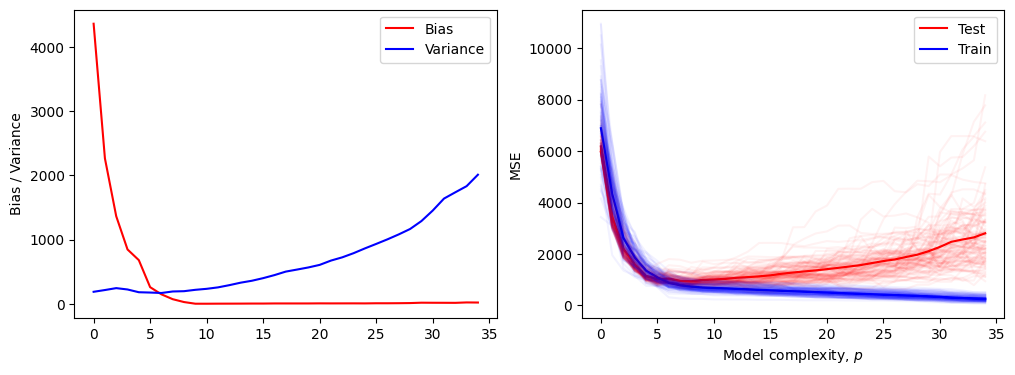

In [2]:
def compute_squared_bias(f: np.ndarray, f_hat: np.ndarray) -> np.ndarray:
  """Compute the bias given ground truth and predictions coming from different estimators
  trained on random datasets R times.

  Shapes:
    N: number of input points in the evaluation / test set
    P: maximum complexity. Also corresponds to the number of models with growing complexities that are trained
    f: (N,)
    f_hat: (R, P, N)

  Returns:
    Bias, array of shape (P,)
  """
  ef = f_hat.mean(axis=0)
  return np.mean((f - ef) ** 2, axis=-1)


def compute_variance(f_hat: np.ndarray) -> np.ndarray:
  """Compute the bias given predictions coming from different estimators trained on random datasets R times.

  Shapes:
    N: number of input points in the evaluation / test set
    P: maximum complexity. Also corresponds to the number of models with growing complexities that are trained
    f_hat: (R, P, N)

  Returns:
    Variance, array of shape (P,)
  """
  r = f_hat.shape[0]
  ef = f_hat.mean(axis=0)
  return np.mean(((f_hat - ef) ** 2).sum(axis=0) / (r - 1), axis=-1)


def compute_mean_squared_error(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
  """Compute the mean sum of squared errors between predictions and a ground truth, over
  the observations from a test set.

  Shapes:
    N: number of input points in the evaluation / test set
    P: maximum complexity. Also corresponds to the number of models with growing complexities that are trained
    y_true: (1 or R, 1, N)
    y_pred: (R, P, N)

  Notes:
    y_true and y_pred naturally broadcast each other, meaning that y_true + y_pred
    results in the element-wise sum across each dimension.
  """
  return np.mean(np.square(y_true - y_pred), axis=-1)


def bias_variance_decomposition(num_rounds: int = 100, max_k: int = 30, num_train: int = 80, num_test: int = 20, noise_std=0.1) -> None:
  """Decompose bias and variance of the MSE error as a function of the maximum polynomial degree of the estimator."""

  # Test data
  x_test, y_test = generate_dataset(num_inputs=num_test, noise_std=noise_std)

  # placeholders
  f_test_samples = np.empty((num_rounds, max_k, num_test))
  f_train_samples = np.empty((num_rounds, max_k, num_train))
  y_train_samples = np.empty((num_rounds, 1, num_train))

  with tqdm.trange(num_rounds * max_k) as pbar:
    for n in range(num_rounds):
      # TODO: generate dataset
      x_train, y_train = generate_dataset(num_inputs=num_train, noise_std=noise_std)
      y_train_samples[n, 0] = y_train.ravel()

      # Fit model of growing complexity
      for k in range(1, max_k + 1):
        # TODO: fit linear regression
        lr = fit_linear_model(x_train, y_train, k_best=k)

        f_test_samples[n, k - 1] = lr.predict(x_test[:, :k]).ravel()
        f_train_samples[n, k - 1] = lr.predict(x_train[:, :k]).ravel()

        pbar.update(1)

    # compute bias and variances
    squared_bias = compute_squared_bias(f(x_test), f_test_samples)
    variance = compute_variance(f_test_samples)

    # compute MSE for train and test sets
    mse_test = compute_mean_squared_error(y_test.ravel(), f_test_samples)
    mse_train = compute_mean_squared_error(y_train_samples, f_train_samples)

    # plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.plot(squared_bias, c="r")
    ax1.plot(variance, c="b")
    ax1.legend(["Bias", "Variance"])
    plt.xlabel("Model complexity, $p$")
    ax1.set_ylabel("Bias / Variance")
    ax2.set_xlabel("Model complexity, $p$")

    ax2.plot(mse_test.mean(axis=0), c="r")
    ax2.plot(mse_train.mean(axis=0), c="b")
    ax2.plot(mse_test.T, c="r", alpha=.05)
    ax2.plot(mse_train.T, c="b", alpha=.05)
    ax2.legend(["Test", "Train"])
    ax2.set_xlabel("Model complexity, $p$")
    ax2.set_ylabel("MSE")

bias_variance_decomposition(num_train=50, num_test=20, num_rounds=100, max_k=35, noise_std=30.0)